In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Import other libraries
import keras
from keras import layers, models, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
# Physical device configuration
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Num GPUs Available: ", len(physical_devices))  # 1 or 0 (1 if GPU is available)

Num GPUs Available:  1


In [4]:
# Constants Variables
EPOCHS = 100

DATA_SET = 'dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
SEED = 123

In [5]:
# Load the dataset
dataset = image_dataset_from_directory(
    DATA_SET,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
)

Found 16242 files belonging to 10 classes.


In [6]:
# Print the class names
class_names = dataset.class_names

# Get the class names
print("Dataset Classes:")
for i, class_name in enumerate(class_names):
    print(f"{i + 1}. {class_name.replace('_', ' ')}")

Dataset Classes:
1. Central Serous Chorioretinopathy
2. Diabetic Retinopathy
3. Disc Edema
4. Glaucoma
5. Healthy
6. Macular Scar
7. Myopia
8. Pterygium
9. Retinal Detachment
10. Retinitis Pigmentosa


In [7]:
# Dataset size
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
print(f"Total samples: {dataset_size}")


Total samples: 16242


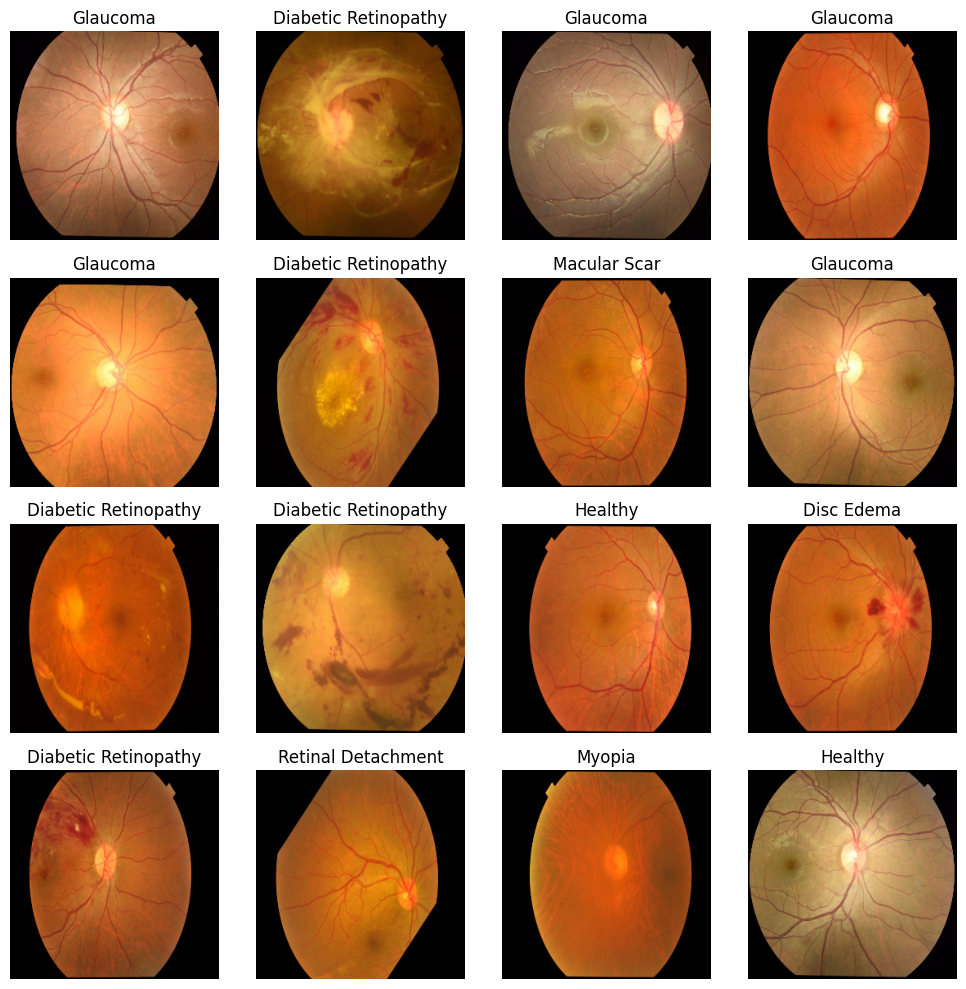

In [12]:
# Set up figure
plt.figure(figsize=(10, 10))

# Take 16 individual samples
for i, (image, label) in enumerate(dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Split ratios
train_ratio, val_ratio, test_ratio  = 0.8, 0.1, 0.1

# Calculate sizes
dataset_size = len(dataset)  # or use cardinality
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size


In [14]:
# Shuffle entire dataset with buffer
dataset = dataset.cache().shuffle(buffer_size=dataset_size, seed=SEED)


In [15]:
# Split into train, validation, and test sets
train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)

val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)


In [16]:
# Data augmentation for training set only
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.Rescaling(1./255)
])


In [17]:
# Apply augmentation to training data only
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Rescale val/test without augmentation
rescale_layer = tf.keras.layers.Rescaling(1./255)

val_dataset = val_dataset.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)


In [18]:
# Batch and prefetch all datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [19]:
print("Train samples:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Validation samples:", tf.data.experimental.cardinality(val_dataset).numpy())
print("Test samples:", tf.data.experimental.cardinality(test_dataset).numpy())


Train samples: 407
Validation samples: 51
Test samples: 51


In [50]:
# # CNN Model Architecture
# def build_custom_cnn(input_shape, num_classes):
#     model = models.Sequential([
#         layers.Input(shape=input_shape),

#         # Block 1
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                       kernel_regularizer=regularizers.l2(0.001)),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),

#         # Block 2
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                       kernel_regularizer=regularizers.l2(0.001)),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),

#         # Block 3
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                       kernel_regularizer=regularizers.l2(0.001)),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.3),

#         # Block 4
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.GlobalAveragePooling2D(),
#         layers.Dropout(0.4),

#         # Output
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model

In [20]:
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        # Optional Dense BottleNeck
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [21]:
# Build the model
model = build_custom_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), num_classes=len(class_names))

In [22]:
# Summary (optional)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                      

In [23]:
# Callbacks for early stopping and model checkpointing
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=1,
    min_lr=1e-6
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('Best_CNN_Model.h5', monitor='val_accuracy', save_best_only=True),
    reduce_lr
]

In [24]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
407/407 [==============================] - 47s 69ms/step - loss: 1.8862 - accuracy: 0.3316 - val_loss: 1.8342 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 2/100
407/407 [==============================] - 27s 67ms/step - loss: 1.6939 - accuracy: 0.3886 - val_loss: 1.9115 - val_accuracy: 0.2808 - lr: 0.0010
Epoch 3/100
407/407 [==============================] - 27s 67ms/step - loss: 1.6301 - accuracy: 0.4126 - val_loss: 1.5277 - val_accuracy: 0.4538 - lr: 0.0010
Epoch 4/100
407/407 [==============================] - 27s 67ms/step - loss: 1.5644 - accuracy: 0.4412 - val_loss: 1.5848 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 5/100
407/407 [==============================] - 27s 67ms/step - loss: 1.4975 - accuracy: 0.4635 - val_loss: 1.4112 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 6/100
407/407 [==============================] - 27s 67ms/step - loss: 1.4139 - accuracy: 0.4844 - val_loss: 2.0267 - val_accuracy: 0.2956 - lr: 0.0010
Epoch 7/100
407/407 [==============================]

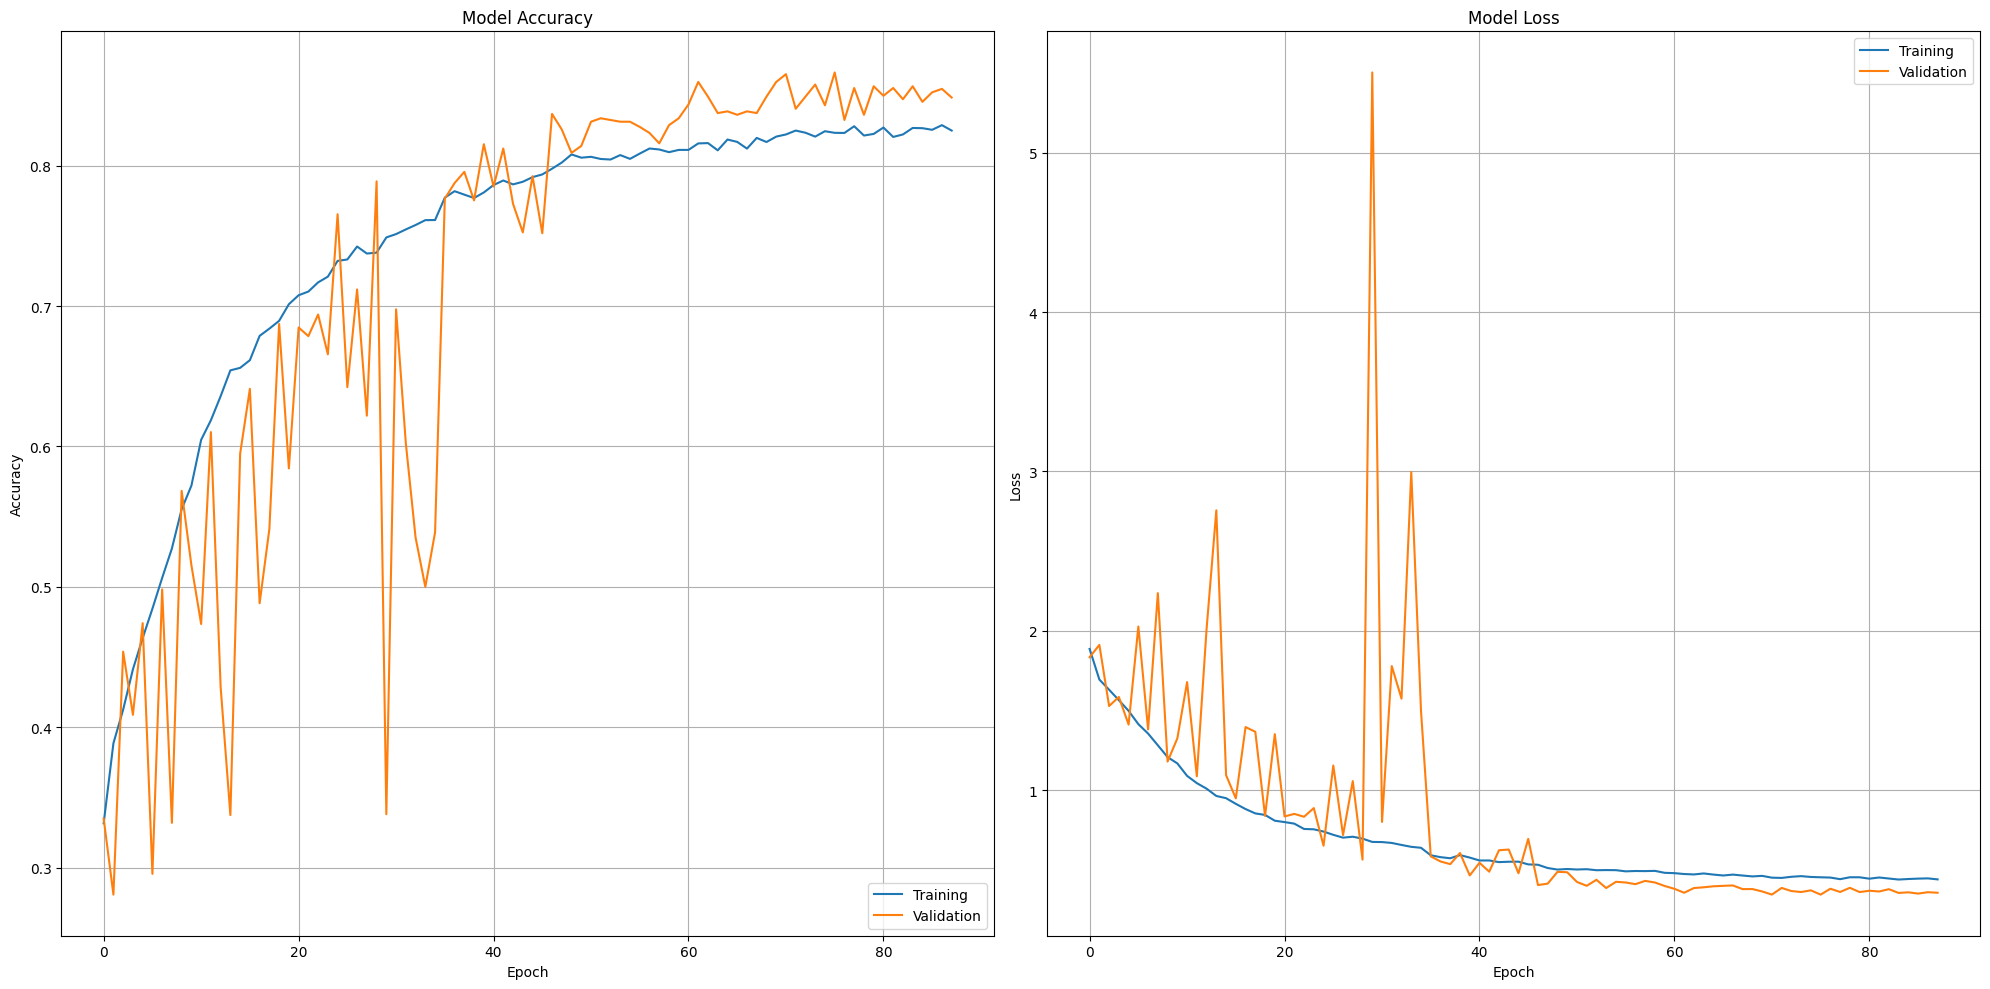

In [57]:
# Create figure and axis objects with a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import classification_report

def evaluate_and_report_model(model, test_dataset, class_names):
    loss, acc = model.evaluate(test_dataset)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}")

    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

evaluate_and_report_model(model, test_dataset, class_names)

51/51 [==============================] - 1s 23ms/step - loss: 0.3806 - accuracy: 0.8418
Test Loss: 0.3806
Test Accuracy: 0.8418
1/1 [==============================] - 0s 71ms/step

=== Classification Report ===
                                  precision    recall  f1-score   support

Central Serous Chorioretinopathy       0.86      0.72      0.78        53
            Diabetic Retinopathy       0.96      0.95      0.96       377
                      Disc Edema       0.96      0.88      0.92        77
                        Glaucoma       0.76      0.77      0.77       291
                         Healthy       0.78      0.86      0.82       286
                    Macular Scar       0.84      0.74      0.79       178
                          Myopia       0.83      0.84      0.84       225
                       Pterygium       1.00      1.00      1.00         9
              Retinal Detachment       0.98      0.98      0.98        49
            Retinitis Pigmentosa       0.92     

In [25]:
model = keras.models.load_model('Best_CNN_Model.h5')

1/1 [==============================] - 0s 21ms/step


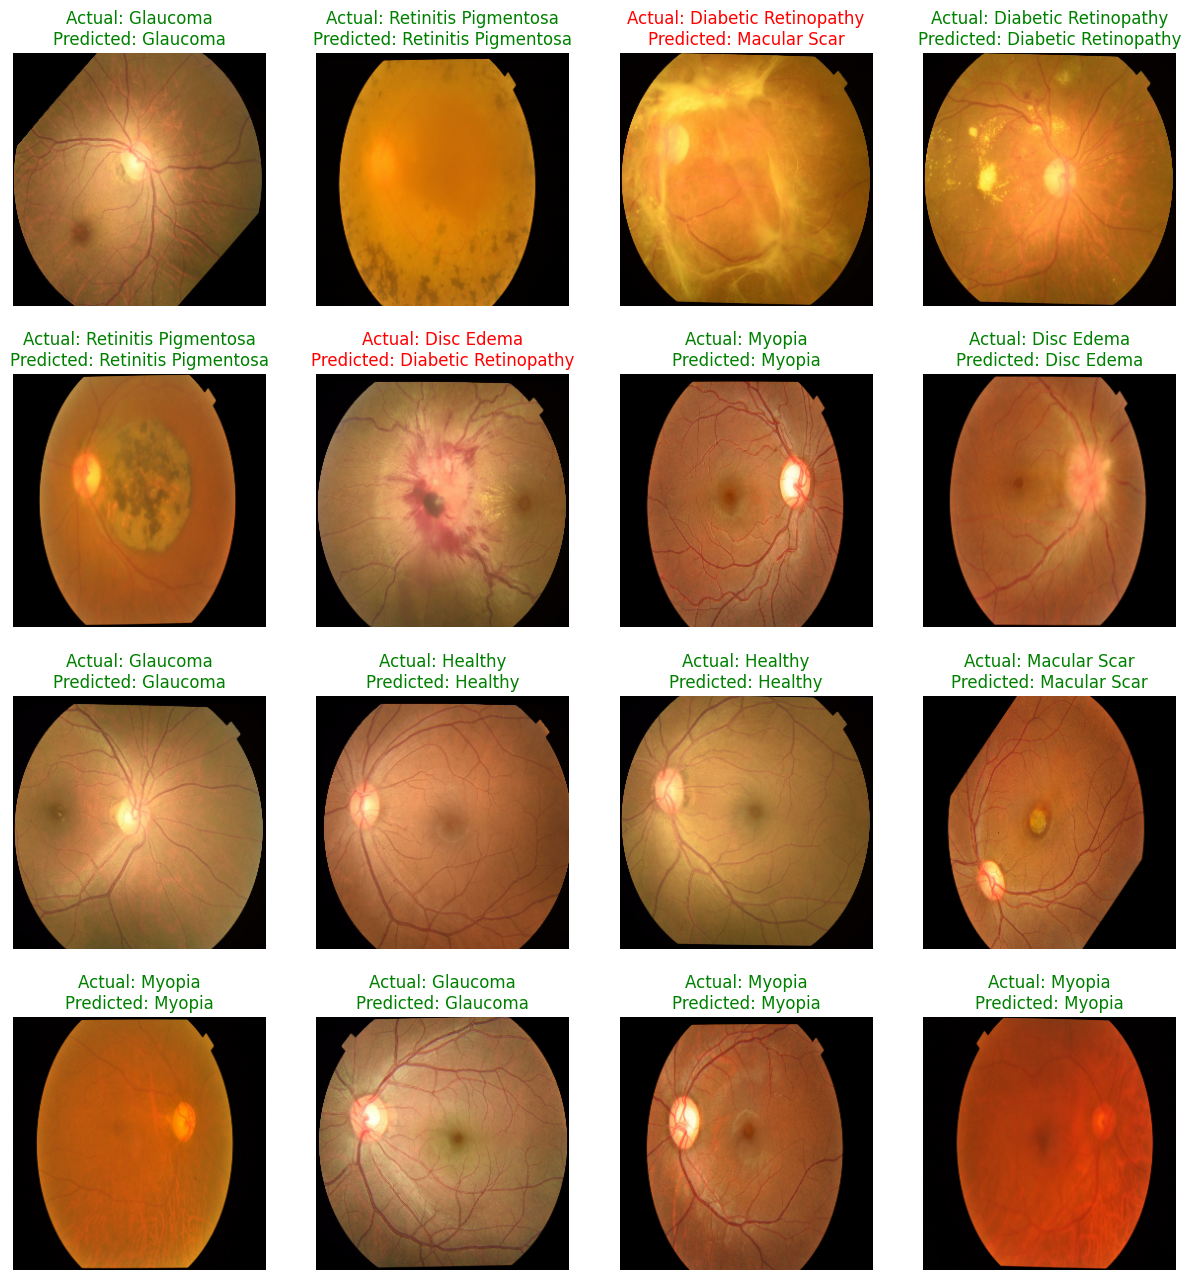

In [31]:
# Predictions using the model
for image_batch, labels_batch in test_dataset.take(1):  # Take one batch from test dataset
    ps = model.predict(image_batch)  # Get model predictions for the batch
    images = (image_batch.numpy() * 255).astype("uint8")  # Convert images to numpy array and scale to [0, 255]
    labels = labels_batch.numpy()  # Convert labels to numpy array

    plt.figure(figsize=(15, 16))  # Create a figure with specified size
    for i in range(16):  # Loop through first 12 images
        ax = plt.subplot(4, 4, i + 1)  # Create a 4x4 subplot grid
        plt.imshow(images[i])  # Display the image
        
        # Get prediction confidence
        confidence = ps[i][ps[i].argmax()] * 100
        
        # Check if prediction is correct
        is_correct = labels[i] == ps[i].argmax()
        color = "green" if is_correct else "red"
        
        # Create title with actual label, predicted label, and confidence
        title = f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[ps[i].argmax()]}"
        plt.title(title, color=color)  # Show title with color
        plt.axis("off")  # Hide axes

In [ ]:
# Load the best model
model = keras.models.load_model("Best_CNN_Model.h5")

In [81]:
# Save the model from the best checkpoint
model.save("model/EyeDiseaseClassifier_v1.h5")

In [ ]:
model.save("model/EyeDiseaseClassifier_TF")